<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [248]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [249]:
## Importação do histórico - UNISIM
df = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim.xlsx')
df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [250]:
df.shape

(132, 11)

In [251]:
df.index = df['t']
t = df['t']
df.drop('t', axis=1, inplace=True)
df

,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
t,,,,,,,,,,
0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327
...,...,...,...,...,...,...,...,...,...,...
3867,24757936,2793256452,4393983,36864922,1.398615,0.003554,113.06,0.695071,0.025850,305
3896,25022300,2822363056,4583991,37475894,1.398453,0.003542,113.06,0.692879,0.025905,306
3927,25304090,2853787229,4789676,38123794,1.398291,0.003530,113.06,0.690695,0.025960,307


In [252]:
df.shape

(132, 10)

<Axes: xlabel='t'>

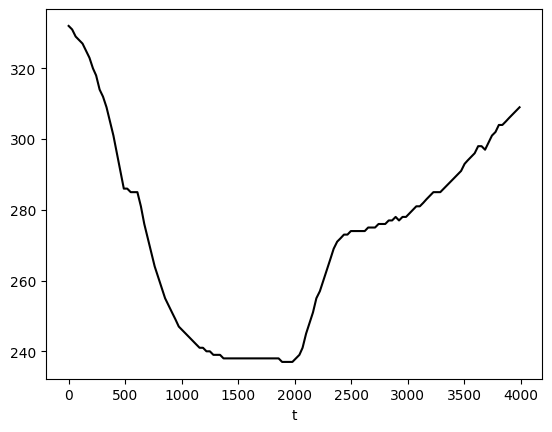

In [253]:
press = df['p']
press.plot(color='black')

In [254]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
# scaled_data = df.to_numpy()

# Define sequence length and features
window_size = 10  # Number of time steps in each sequence
features = len(df.columns)

scaled_data.shape

(132, 10)

In [255]:
# Create sequences and corresponding labels
X = []
y = []
for i in range(len(scaled_data) - window_size):
    seq = scaled_data[i:i+window_size]
    label = scaled_data[i+window_size][-1]
    X.append(seq)
    y.append(label)

In [256]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((122, 10, 10), (122,))

In [257]:
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size
train_size, val_size, test_size

(85, 18, 19)

In [258]:
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85, 10, 10), (85,), (18, 10, 10), (18,), (19, 10, 10), (19,))

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 10, 128)             │          71,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 10, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,025 (519.63 KB)

 Trainable params: 133,025 (519.63 KB)

 Non-trainable params: 0 (0.00 B)

In [260]:
cp = ModelCheckpoint('model/model.keras', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [261]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, callbacks=[cp])

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.1061 - root_mean_squared_error: 0.3256 - val_loss: 0.2277 - val_root_mean_squared_error: 0.4772
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0882 - root_mean_squared_error: 0.2967 - val_loss: 0.1993 - val_root_mean_squared_error: 0.4464
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0769 - root_mean_squared_error: 0.2772 - val_loss: 0.1733 - val_root_mean_squared_error: 0.4163
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0781 - root_mean_squared_error: 0.2793 - val_loss: 0.1496 - val_root_mean_squared_error: 0.3868
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0620 - root_mean_squared_error: 0.2489 - val_loss: 0.1282 - val_root_mean_squared_error: 0.3581
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295 - val_loss: 0.1088 - val_root_mean_squared_error: 0.3299
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.053

In [262]:
from tensorflow.keras.models import load_model
model = load_model('model/model.keras')

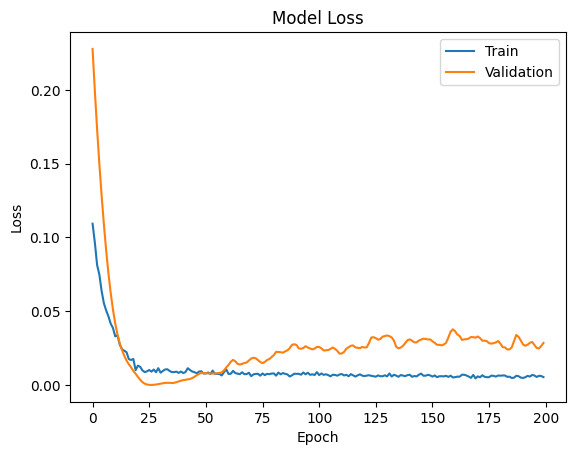

In [263]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [264]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict temperatures using the trained model
predictions = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Mean Absolute Error (MAE): 0.010767671639238979
Mean Squared Error (MSE): 0.00016239460688580371
Root Mean Squared Error (RMSE): 0.012743414255442053


In [265]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


,Test Predictions,Actuals
0,0.571066,0.557895
1,0.580305,0.568421
2,0.589361,0.589474
3,0.598377,0.600000
4,0.607517,0.610526
5,0.618557,0.621053
6,0.631434,0.642105
7,0.644499,0.642105
8,0.657611,0.631579
9,0.670514,0.652632


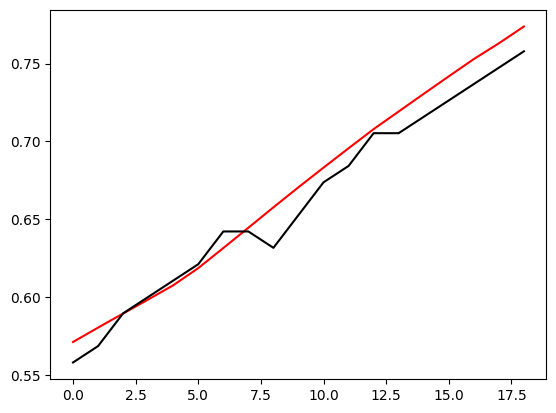

In [266]:
plt.plot(test_results['Test Predictions'], color='red')
plt.plot(test_results['Actuals'], color='black')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


(     Predictions   Actuals
 0       0.665147  0.789474
 1       0.654722  0.757895
 2       0.642781  0.715789
 3       0.629945  0.673684
 4       0.614973  0.621053
 ..           ...       ...
 117     0.730567  0.715789
 118     0.741798  0.726316
 119     0.752912  0.736842
 120     0.763022  0.747368
 121     0.773847  0.757895
 
 [122 rows x 2 columns],
 0.005276085517753115)

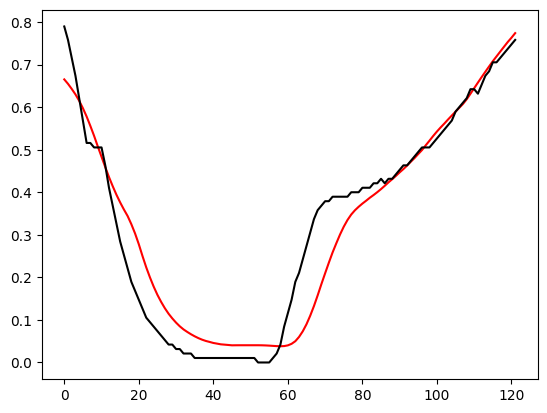

In [267]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], color='red')
  plt.plot(df['Actuals'][start:end], color='black')
  return df, mse(predictions, y)

plot_predictions(model, X, y, 0, len(X))

In [268]:
# y_true values
y_copies = np.repeat(y.reshape(-1, 1), X.shape[-1], axis=-1)
true_y = scaler.inverse_transform(y_copies)

# predicted values
y_pred = model.predict(X)
true_y_pred_copies = np.repeat(y_pred.reshape(-1, 1), X.shape[-1], axis=-1)
true_y_pred = scaler.inverse_transform(true_y_pred_copies)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [269]:
(true_y[:, -1] - press.values[window_size:]).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [270]:
t = t[1:true_y[:, -1].shape[0]+1]

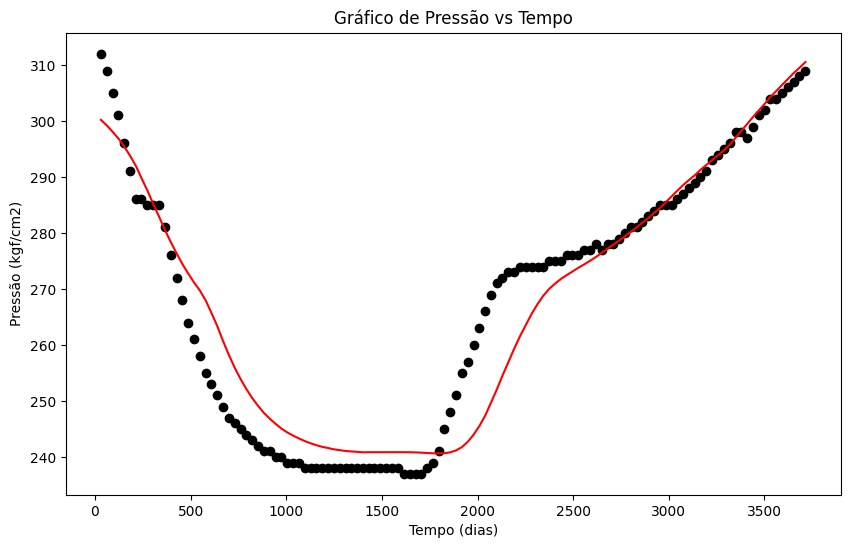

In [271]:
# Plota gráfico do histórico de p x t

plt.figure(figsize=(10, 6))
plt.scatter(t, true_y[:, -1], color='black')
plt.plot(t, true_y_pred[:, -1], color='red')
plt.xlabel('Tempo (dias)')
plt.ylabel('Pressão (kgf/cm2)')
plt.title('Gráfico de Pressão vs Tempo')
plt.show()